In [257]:
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import linear_model
import seaborn as sns
import statsmodels.formula.api as smf
from IPython.display import display
import sklearn
from sklearn.preprocessing import normalize
import math
import statsmodels.api as sm
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
os.getcwd()
os.chdir('/Users/kylehoward/desktop/thinkful/thinkful-2/capstone_1') 
os.getcwd()

'/Users/kylehoward/Desktop/Thinkful/Thinkful-2/Capstone_1'

In [258]:
'''
This project is a look at every shot in the from the 2014-2015 NBA season. The goal is to predict whether a shot will 
go in and also to gain understanding about what constitutes a 'good' shot. This is a classification problem as 
I am attempting to see if a shot will go in or not. 

The models used in this project are: Random Forrest, KNN, 
Logistic Regression, and Support Vectors. 

Based on sklearn similarity scores and the area under the ROC random forrest
model performed the best but SVC was dramatically better at selecting made shots although selecting much fewer. 

Layout is as follows:

-Feature engineering
-RFC
-KNN
-Logistic Regression
-SVC
-Visualizations
'''

"\nThis project is a look at every shot in the from the 2014-2015 NBA season. The goal is to predict whether a shot will \ngo in and also to gain understanding about what constitutes a 'good' shot. This is a classification problem as \nI am attempting to see if a shot will go in or not. \n\nThe models used in this project are: Random Forrest, KNN, \nLogistic Regression, and Support Vectors. Based on sklearn similarity scores and the area under the ROC random forrest\nmodel performed the best but logistic and SVC were better at selecting made shots. Layout is as follows:\n\n-Feature engineering\n-RFC\n-KNN\n-Logistic Regression\n-SVC\n-Visualizations\n"

In [318]:
# Importing data for every shot made in the NBA for 2014-2015 season. Data taken from Kaggle
data = ("shot_logs.csv")
df = pd.read_csv(data, usecols=[4,5,6,7,8,9,10,11,12,13,16,17,18,20])


In [260]:
# We have plenty of data so dropping NA
df = df.dropna()

In [261]:
# Inspecting the data
df.describe()

,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,FGM,PTS,player_id
count,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000
mean,0.252396,6.476164,2.471454,12.453344,1.989233,2.748202,13.443758,2.258363,4.121706,0.456156,1.005469,157334.912965
std,13.311418,4.681245,1.137898,5.763265,3.411188,2.957237,8.777113,0.437736,2.751587,0.498076,1.131129,79304.953702
min,-53.000000,1.000000,1.000000,0.000000,0.000000,-100.500000,0.000000,2.000000,0.000000,0.000000,0.000000,708.000000
25%,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,2.300000,0.000000,0.000000,101162.000000
50%,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.400000,2.000000,3.700000,0.000000,0.000000,201939.000000
75%,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.400000,3.000000,5.300000,1.000000,2.000000,202704.000000
max,53.000000,37.000000,7.000000,24.000000,32.000000,24.900000,43.500000,3.000000,53.200000,1.000000,3.000000,204060.000000


In [262]:
# Inspecting the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122502 entries, 0 to 128067
Data columns (total 14 columns):
FINAL_MARGIN      122502 non-null int64
SHOT_NUMBER       122502 non-null int64
PERIOD            122502 non-null int64
GAME_CLOCK        122502 non-null object
SHOT_CLOCK        122502 non-null float64
DRIBBLES          122502 non-null int64
TOUCH_TIME        122502 non-null float64
SHOT_DIST         122502 non-null float64
PTS_TYPE          122502 non-null int64
SHOT_RESULT       122502 non-null object
CLOSE_DEF_DIST    122502 non-null float64
FGM               122502 non-null int64
PTS               122502 non-null int64
player_id         122502 non-null int64
dtypes: float64(4), int64(8), object(2)
memory usage: 14.0+ MB


In [263]:
# Inspecting defender distance and determining a reasonable cap.
# We will cap it at two standard deviations and round up to ten. 
df['CLOSE_DEF_DIST'].describe()

count    122502.000000
mean          4.121706
std           2.751587
min           0.000000
25%           2.300000
50%           3.700000
75%           5.300000
max          53.200000
Name: CLOSE_DEF_DIST, dtype: float64

In [264]:
# -------------------------------- Feature Building ---------------------------------
# Converting the data types and limiting defender distance to <= 10 ft and shot distance to <= 25
df['PTS_TYPE'].astype(int)
df['SHOT_DIST'].astype(int)
df['CLOSE_DEF_DIST'].astype(int)
df = df[df.CLOSE_DEF_DIST <= 10]
df = df[df.SHOT_DIST <= 25]


(110124, 14)

In [265]:
# Creating categorical features for shot distance
df['S_IS_CLOSE'] = np.where(df['SHOT_DIST']<=6, 1, 0)
df['S_IS_SHORT'] = np.where((df['SHOT_DIST']<=12) & (df['SHOT_DIST']>6), 1, 0)
df['S_IS_MID'] = np.where((df['SHOT_DIST']<=18) & (df['SHOT_DIST']>12), 1, 0)
df['S_IS_LONG'] = np.where(df['SHOT_DIST']>18, 1, 0)


In [319]:
# Creating some new features.  
df['IS_THREE'] = np.where(df['PTS_TYPE']==3, 1, 0)
df['TOUCH_TIME_SQUARED'] = df['TOUCH_TIME'] ** 2
df['TOUCH_TIME_THIRD'] = df['TOUCH_TIME'] ** 3

# Inverting defender distance so a close defender has a high value and defender who is far away has a low value
df['DISTANCE_RECIP'] = df['CLOSE_DEF_DIST'] - 10
df['DISTANCE_RECIP'] = df['DISTANCE_RECIP'].abs()

# Creating a feature where defender distance and shot distance are considered 
# This becomes the most successful feature
df['DIST_DIST'] = df['DISTANCE_RECIP'] * df['SHOT_DIST'] 

df['DIST_SQR_DIST'] = df['DISTANCE_RECIP'] ** df['SHOT_DIST']
# Filling any remaining NA values
df.fillna(0, inplace=True)

In [320]:
# Seeing if I can manipulate dribbles 
df['DRIBBLES_SQUARED'] = df['DRIBBLES'] ** 2
df['DRIBBLES_SQRT'] = df['DRIBBLES'] ** .5
df['DRIBBLES_THIRD'] = df['DRIBBLES'] ** 3
df['DRIBBLES_LOG'] = np.log(df.DRIBBLES)
df['DRIBBLES-TT'] = df['DRIBBLES'] * df['TOUCH_TIME_SQUARED']
df['TT_SQ_DR'] = df['TOUCH_TIME'] ** df['DRIBBLES']
df.head(10)


/Users/kylehoward/Desktop/Thinkful/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,...,TOUCH_TIME_THIRD,DISTANCE_RECIP,DIST_DIST,DIST_SQR_DIST,DRIBBLES_SQUARED,DRIBBLES_SQRT,DRIBBLES_THIRD,DRIBBLES_LOG,DRIBBLES-TT,TT_SQ_DR
0,24,1,1,1:09,10.8,2,1.9,7.7,2,made,...,6.859,8.7,66.99,1.715135e+07,4,1.414214,8,0.693147,7.22,3.610000e+00
1,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,...,0.512,3.9,109.98,4.656096e+16,0,0.000000,0,-inf,0.00,1.000000e+00
2,24,3,1,0:00,0.0,3,2.7,10.1,2,missed,...,19.683,9.1,91.91,4.856440e+09,9,1.732051,27,1.098612,21.87,1.968300e+01
3,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,...,6.859,6.6,113.52,1.247831e+14,4,1.414214,8,0.693147,7.22,3.610000e+00
4,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,...,19.683,8.9,32.93,3.256440e+03,4,1.414214,8,0.693147,14.58,7.290000e+00
5,24,6,2,8:15,9.1,2,4.4,18.4,2,missed,...,85.184,7.4,136.16,9.859699e+15,4,1.414214,8,0.693147,38.72,1.936000e+01
6,24,7,4,10:15,14.5,11,9.0,20.7,2,missed,...,729.000,3.9,80.73,1.718056e+12,121,3.316625,1331,2.397895,891.00,3.138106e+10
7,24,8,4,8:00,3.4,3,2.5,3.5,2,made,...,15.625,7.9,27.65,1.385782e+03,9,1.732051,27,1.098612,18.75,1.562500e+01
8,24,9,4,5:14,12.4,0,0.8,24.6,3,missed,...,0.512,2.7,66.42,4.088355e+10,0,0.000000,0,-inf,0.00,1.000000e+00
9,1,1,2,11:32,17.4,0,1.1,22.4,3,missed,...,1.331,9.8,219.52,1.597585e+22,0,0.000000,0,-inf,0.00,1.000000e+00


In [268]:
# Trying out categorical features to see if we can increase accuracy
df['D_1'] = np.where(df['CLOSE_DEF_DIST']<=2, 1, 0)
df['D_2'] = np.where((df['CLOSE_DEF_DIST']<=4) & (df['CLOSE_DEF_DIST']>2), 1, 0)
df['D_3'] = np.where((df['CLOSE_DEF_DIST']<=6) & (df['CLOSE_DEF_DIST']>4), 1, 0)
df['D_4'] = np.where((df['CLOSE_DEF_DIST']<=8) & (df['CLOSE_DEF_DIST']>6), 1, 0)
df['D_5'] = np.where((df['CLOSE_DEF_DIST']<=10) & (df['CLOSE_DEF_DIST']>8), 1, 0)

# Inspecting df
df.shape

(110124, 35)

In [269]:
# Making dummy variables for player id
for elem in df['player_id'].unique():
    df[str(elem)] = df['player_id'] == elem
df.columns
df_p = df.iloc[:, 34:]
df_p.fillna
df_p = df_p.astype(int)
players = df_p
df_p.head()
df['player_id'] = df_p

In [270]:
# ---------------------------------------- RFC --------------------------------------------
# Running random forrest classifier first to test feature importances and because we want to learn which choices
# in a basketball game are most predictive of a made shot as a side effect of the project. 
# Did not include individual players as the sheer volume of players would not make sense for a decision tree.
rfc = ensemble.RandomForestClassifier()
y = df['FGM']
X = df[['FINAL_MARGIN', 'PERIOD', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'TOUCH_TIME_SQUARED', 
        'TOUCH_TIME_THIRD','DISTANCE_RECIP', 'DIST_DIST', 'DRIBBLES_SQUARED', 'DRIBBLES_SQRT', 'DRIBBLES_THIRD',
        'DRIBBLES-TT', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 
        'S_IS_CLOSE', 'S_IS_SHORT', 'S_IS_MID', 'S_IS_LONG']]
X = normalize(X)
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
print('Percentage accuracy')
rfc.score(X_test, y_test) 

Percentage accuracy


0.56773315180394823

In [271]:
# Inspecting the feature importances
importances = rfc.feature_importances_
print(importances)

[ 0.08637419  0.07928791  0.02894301  0.06561864  0.07510417  0.08366432
  0.06446908  0.06716978  0.08788839  0.07453152  0.02908917  0.02911875
  0.02739316  0.03245323  0.01822192  0.0288451   0.02249991  0.00909637
  0.00328992  0.03592637  0.01167374  0.01162684  0.02771452]


In [272]:
# Adding estimators to see if it has an effect on feature importances
rfc = ensemble.RandomForestClassifier(n_estimators=30)
y = df['FGM']
X = df[['FINAL_MARGIN', 'PERIOD', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'TOUCH_TIME_SQUARED', 
        'TOUCH_TIME_THIRD','DISTANCE_RECIP', 'DIST_DIST', 'DRIBBLES_SQUARED', 'DRIBBLES_SQRT', 'DRIBBLES_THIRD',
        'DRIBBLES-TT', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 
        'S_IS_CLOSE', 'S_IS_SHORT', 'S_IS_MID', 'S_IS_LONG']]
X = normalize(X)
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
print('Percentage accuracy')
rfc.score(X_test, y_test) 



Percentage accuracy


0.57530633083730431

In [273]:
# Checking to see how consistent the model is
cross_val_score(rfc, X, y, cv=5)

array([ 0.57938706,  0.58047673,  0.57448354,  0.57602724,  0.57827824])

In [274]:
# Inspecting the feature importances to help reduce features as many are redundant and/or not applicable
importances = rfc.feature_importances_
print(importances)

[ 0.08410047  0.07986331  0.02820504  0.06784662  0.07550799  0.08058998
  0.06647749  0.06725616  0.08277838  0.07518226  0.02869147  0.02833026
  0.02841031  0.03160355  0.01876916  0.03004016  0.02133092  0.00848518
  0.00289421  0.04520341  0.01186473  0.01075953  0.02580941]


In [275]:
# Reducing features to most valuable as well as removing redundant features 
X = df[['FINAL_MARGIN', 'PERIOD', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 
        'DIST_DIST']]
X = normalize(X)
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred_test = rfc.predict(X_test)
print('Percentage accuracy')
rfc.score(X_test, y_test) 

Percentage accuracy


0.57836963921034712

In [313]:
# Tuning model to have fever nodes and more estimators. Total gain from initial trial is .035
rfc = ensemble.RandomForestClassifier(n_estimators=300, max_depth=6)
y = df['FGM']
X = df[['PERIOD', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'DIST_DIST']]
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
rfc.fit(X_training, y_training)
y_pred = rfc.predict(X_test)
print('Percentage accuracy')
rfc.score(X_test, y_test) 

Percentage accuracy


0.61083219877467665

In [315]:
# Making sure model is still consistent
cross_val_score(rfc, X, y, cv=5)

array([ 0.61965948,  0.61271283,  0.60971623,  0.60794552,  0.61183255])

In [278]:
# Since we are mostly interested in made shots comparing how well the model performs when selecting 'made'
# 65.2% on selecting 'made' 59.7% on selecting missed
confusion_matrix(y_test, y_pred)


array([[10579,  2006],
       [ 7161,  3758]])

In [279]:
# Creating a variable for how accurate the model is when determining when a shot will go in
per = confusion_matrix(y_test, y_pred)
per_1 = per[0]
per_2 = per[1]
per_t = per_1[1] + per_2[1]
per_f = per_2[1] / per_t

In [280]:
# Comparing our model to season long FG% to make sure just selecting 'made' isn't statistically similar
hit = df["FGM"].sum()
tot = len(df['FGM'])
percent = hit / tot
percent_p = percent * 100
print('NBA Average Field Goal Percentage')
print(percent_p)
print('RFC Percentage Accuracy When Predicting Made FG')
print(per_f * 100)

NBA Average Field Goal Percentage
46.4703425229741
RFC Percentage Accuracy When Predicting Made FG
65.1977793199


/Users/kylehoward/Desktop/Thinkful/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


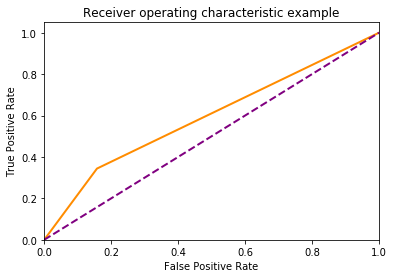

ROC Area Under the Curve:
0.593169775502


In [316]:
# Plotting ROC graph so we can compare visually with all models and compute our AUC
fpr_r, tpr_r, thresholds = sklearn.metrics.roc_curve(y_test, y_pred)
a = roc_auc_score(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr_r, tpr_r, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='purple', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print('ROC Area Under the Curve:')
print(a)

In [282]:
# Checking to see how highly correlated our features are. Some are obviously correlated but it seems that they can 
# unique information
correlation_matrix = X.corr()
display(correlation_matrix)

,PERIOD,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,DIST_DIST
PERIOD,1.000000,0.053394,0.019390,-0.011247,0.031405
TOUCH_TIME,0.053394,1.000000,-0.064957,-0.152422,0.054834
SHOT_DIST,0.019390,-0.064957,1.000000,0.614985,0.795335
CLOSE_DEF_DIST,-0.011247,-0.152422,0.614985,1.000000,0.090207
DIST_DIST,0.031405,0.054834,0.795335,0.090207,1.000000


In [283]:
#-----------------------------------KNN-----------------------------------------------
# In KNN I will include player_id since we are looking for the Eucleidean distance of each and are not 
# concerned about the algorithm making "yes/no' decisions unlike RFC
y = df['FGM']
X = df[['FINAL_MARGIN', 'PERIOD', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'TOUCH_TIME_SQUARED', 
        'TOUCH_TIME_THIRD','DISTANCE_RECIP', 'DIST_DIST', 'DRIBBLES_SQUARED', 'DRIBBLES_SQRT', 'DRIBBLES_THIRD',
        'DRIBBLES-TT', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 
        'S_IS_CLOSE', 'S_IS_SHORT', 'S_IS_MID', 'S_IS_LONG', 'player_id']]

# Normalizing 'X' so all features can weigh in equally
X = normalize(X)
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]

In [284]:
# Viewing initial score
knn = neighbors.KNeighborsClassifier()
knn.fit(X_training, y_training)
y_pred = knn.predict(X_test)
print('Percentage accuracy')
print(knn.score(X_test, y_test))

Percentage accuracy
0.557054118448


In [285]:
# Checking to be sure our model is consistent
cross_val_score(rfc, X, y, cv=5)

array([ 0.61779796,  0.61125993,  0.60903519,  0.60490352,  0.60624773])

In [286]:
# Tuning the model. Tuning k to 250 to reduce noise and potential for overfitting. Also creating smoother boundaries. 
# Weighing each data point by distance since we will be setting k to 250
knn = neighbors.KNeighborsClassifier(n_neighbors=250, weights='distance')
knn.fit(X_training, y_training)
y_pred = knn.predict(X_test)
print('Percentage accuracy')
print(knn.score(X_test, y_test))

Percentage accuracy
0.602408100749


In [287]:
# Reducing features to see how our successful group in RFC work with 'player_id
# Also tried trial and error with other features that weren't the strongest in RFC
# Total gain from initial trial is .045
X = df[['PERIOD', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'DIST_DIST', 'player_id']]
X = normalize(X)
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
knn.fit(X_training, y_training)
y_pred = knn.predict(X_test)
print('Percentage accuracy')
print(knn.score(X_test, y_test))

Percentage accuracy
0.602918652144


In [288]:
# 63.9% on selecting 'made' 59.7% on selecting missed
confusion_matrix(y_test, y_pred)

array([[10347,  2238],
       [ 7095,  3824]])

/Users/kylehoward/Desktop/Thinkful/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


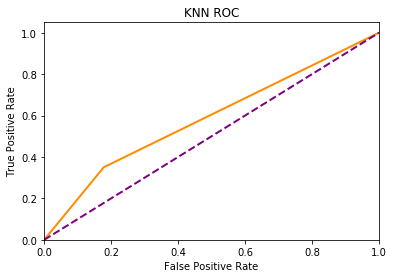

ROC Area Under the Curve:
0.58619223514


In [289]:
# Plotting ROC graph so we can compare visually with all models and compute our AUC
fpr_k, tpr_k, thresholds = sklearn.metrics.roc_curve(y_test, y_pred)
a = roc_auc_score(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr_k, tpr_k, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='purple', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC')
plt.legend(loc="lower right")
plt.show()
print('ROC Area Under the Curve:')
print(a)

In [290]:
#------------------------- sklearn Logistic regression ------------------------------------
# Attempting logistic regression to see if there is a linear relationship between the predictions
lr = LogisticRegression()
y = df['FGM']
[['FINAL_MARGIN', 'PERIOD', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'TOUCH_TIME_SQUARED', 
        'TOUCH_TIME_THIRD','DISTANCE_RECIP', 'DIST_DIST', 'DRIBBLES_SQUARED', 'DRIBBLES_SQRT', 'DRIBBLES_THIRD',
        'DRIBBLES-TT', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 
        'S_IS_CLOSE', 'S_IS_SHORT', 'S_IS_MID', 'S_IS_LONG', 'player_id']]
X = normalize(X)
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
fit = lr.fit(X_training, y_training)
y_pred = lr.predict(X_test)
print('Percentage accuracy')
print(lr.score(X_test, y_test))

Percentage accuracy
0.601769911504


In [291]:
# Reducing features to those that have been the most successful. Also worked with features that didn't make the cut
# for our previous models but left them out due to lack of success
lr = LogisticRegression()
y = df['FGM']
X = df[['PERIOD', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'DIST_DIST', 'player_id']]
X = normalize(X)
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
fit = lr.fit(X_training, y_training)
y_pred = lr.predict(X_test)
print('Percentage accuracy')
print(lr.score(X_test, y_test))


Percentage accuracy
0.601769911504


In [292]:
# Tuning our model to increase regularization slightly
lr = LogisticRegression(C=.65)
fit = lr.fit(X_training, y_training)
y_pred = lr.predict(X_test)
print('\n Percentage accuracy')
print(lr.score(X_test, y_test))


 Percentage accuracy
0.602025187202


In [293]:
# 68.4% on selecting 'made' 58.3% on selecting missed. Less frquency selecting 'made' then other models. But much 
# higher success rate. 
confusion_matrix(y_test, y_pred)

array([[11244,  1341],
       [ 8013,  2906]])

In [294]:
# Attempted to remove 'player_id to lesser success
'''X = df[['TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'DIST_DIST']]
X = normalize(X)
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
fit = lr.fit(X_training, y_training)
y_pred = lr.predict(X_test)
print('\n Percentage accuracy')
print(lr.score(X_test, y_test))'''

"X = df[['TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'DIST_DIST']]\nX = normalize(X)\nX_training = X[:86620]\ny_training = y[:86620]\nX_test = X[86620:]\ny_test = y[86620:]\nfit = lr.fit(X_training, y_training)\ny_pred = lr.predict(X_test)\nprint('\n Percentage accuracy')\nprint(lr.score(X_test, y_test))"

/Users/kylehoward/Desktop/Thinkful/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


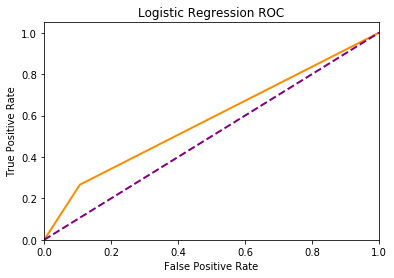

ROC Area Under the Curve:
0.579793082467


In [295]:
# Plotting ROC graph so we can compare visually with all models and compute our AUC
fpr_l, tpr_l, thresholds = sklearn.metrics.roc_curve(y_test, y_pred)
plt.figure()
a = roc_auc_score(y_test, y_pred)
lw = 2
plt.plot(fpr_l, tpr_l, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='purple', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC')
plt.legend(loc="lower right")
plt.show()
print('ROC Area Under the Curve:')
print(a)

In [296]:
#-------------------------------SVC--------------------------------
# Attempting Support Vector Classification to see if calculating a hyperplane boundary will improve our performance
# I did not include all features in this trial to keep from bogging down my machine.
svm = SVC()
y = df['FGM']
X = df[['PERIOD', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'DIST_DIST', 'player_id']]
X = normalize(X)
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
svm.fit(X_training, y_training)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [297]:
svm.score(X_test, y_test)
y_pred = svm.predict(X_test)

In [298]:
# Dropping the 'player_id'
X = df[['PERIOD', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'DIST_DIST']]
X = normalize(X)
X_training = X[:86620]
y_training = y[:86620]
X_test = X[86620:]
y_test = y[86620:]
svm.fit(X_training, y_training)
y_pred = svm.predict(X_test)
svm.score(X_test, y_test)

0.59611130020422054

In [299]:
# Tuning the cost function
svm = SVC(C=5)
svm.fit(X_training, y_training)
y_pred = svm.predict(X_test)
svm.score(X_test, y_test)

0.60036589516678007

In [300]:
# 72.2% on selecting 'made' 57.5% on selecting missed. Success rate for 'made' is by far most successful
confusion_matrix(y_test, y_pred)

array([[11713,   872],
       [ 8653,  2266]])

In [ ]:
# Creating a variable for how accurate the model is when determining when a shot will go in
per = confusion_matrix(y_test, y_pred)
per_1 = per[0]
per_2 = per[1]
per_t = per_1[1] + per_2[1]
per_f = per_2[1] / per_t

In [ ]:
# Comparing our model to season long FG% to make sure just selecting 'made' isn't statistically similar
hit = df["FGM"].sum()
tot = len(df['FGM'])
percent = hit / tot
percent_p = percent * 100
print('NBA Average Field Goal Percentage')
print(percent_p)
print('RFC Percentage Accuracy When Predicting Made FG')
print(per_f * 100)

/Users/kylehoward/Desktop/Thinkful/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


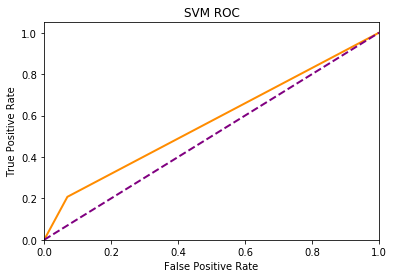

ROC Area Under the Curve:
0.569119663002


In [301]:
# Plotting ROC graph so we can compare visually with all models and compute our AUC
fpr_s, tpr_s, thresholds = sklearn.metrics.roc_curve(y_test, y_pred)
a = roc_auc_score(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr_s, tpr_s, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='purple', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC')
plt.legend(loc="lower right")
plt.show()
print('ROC Area Under the Curve:')
print(a)

In [391]:
#-----------------------------------------Visuailzations-------------------------------------------

In [302]:
# Creating a decision tree to visualize a simple example of our RFC estimators
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1, # Making sure it is only working with one feature per node
    max_depth=4, # Setting the depth of the tree to 4. In our model it was 6 but I simplified for ease of viewing in the presentation
)
decision_tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

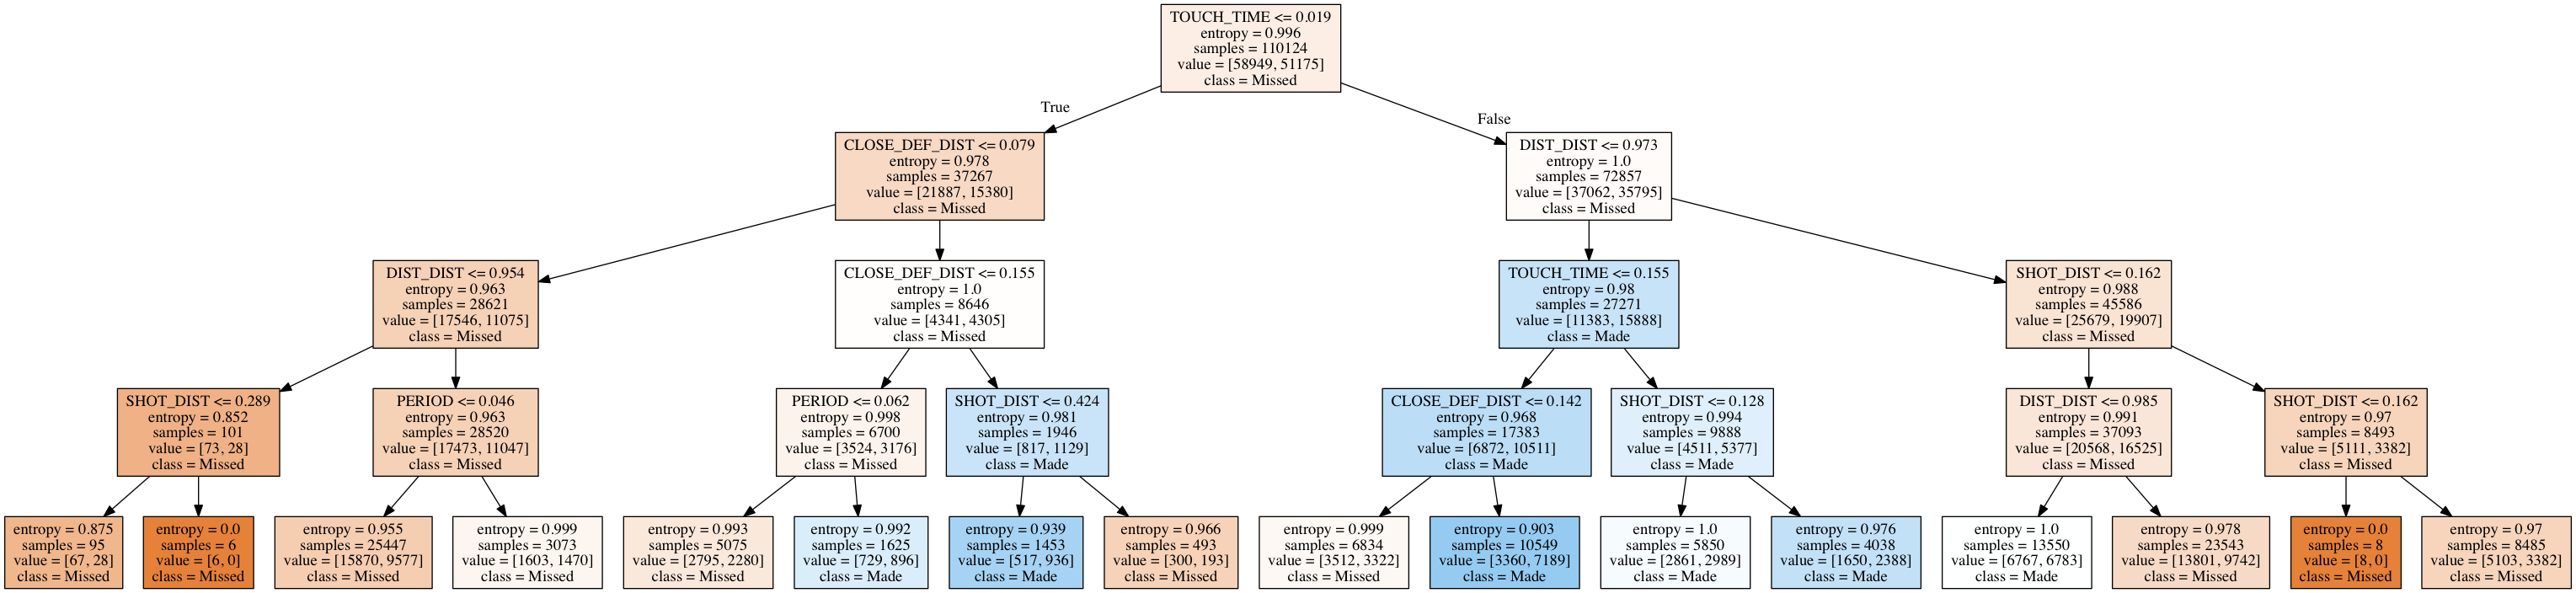

In [303]:
# Naming features and graphing decision tree
names = ['PERIOD', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'DIST_DIST']
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=names,
    class_names=['Missed', 'Made'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

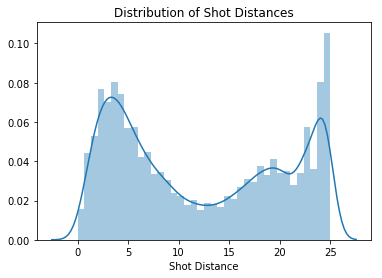

In [304]:
# Viewing distributions for features
z = df['SHOT_DIST']
plt.xlabel('Shot Distance')
sns.distplot(z)
plt.title('Distribution of Shot Distances')
plt.xlabel('Shot Distance')

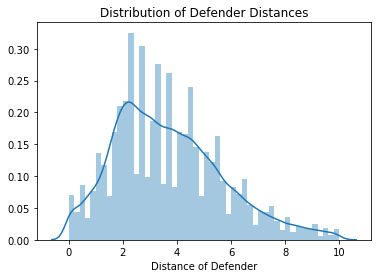

In [305]:
# Viewing distributions for features
z = df['CLOSE_DEF_DIST']
plt.xlabel('Distance of Defender')
sns.distplot(z)
plt.title('Distribution of Defender Distances')
plt.xlabel('Distance of Defender')

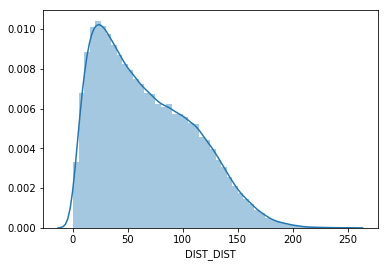

In [306]:
# Viewing distributions for features. Did not use this in presentation so left off labels
z = df['DIST_DIST']
sns.distplot(z)

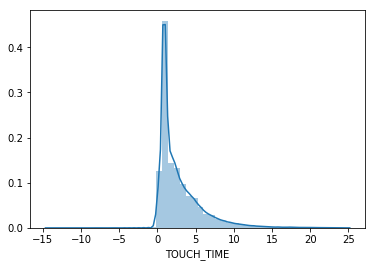

In [307]:
# Viewing distributions for features. Did not use this in presentation so left off labels
z = df['TOUCH_TIME']
sns.distplot(z)

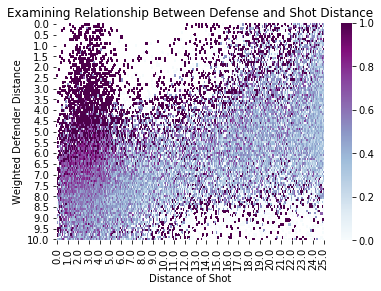

In [308]:
# Creating a heatmap to help visualize the relationship between distance of defender, distance of shot and how that 
# affects whether the shot goes in
x = df['SHOT_DIST']
y = df['FGM'] 
z = df['DISTANCE_RECIP']
df_ = pd.DataFrame()
df_['SHOT_DIST'] = x
df_['FGM'] = y
df_['DISTANCE_RECIP'] = z
x = pd.Series(x, name="Distance of Shot")
y = pd.Series(z, name="Weighted Defender Distance")
df_ = df_.groupby(['DISTANCE_RECIP','SHOT_DIST'], as_index=False).mean()
df_ = df_.pivot(index='DISTANCE_RECIP', columns='SHOT_DIST', values='FGM')
sns.heatmap(df_, cmap='BuPu')
plt.title('Examining Relationship Between Defense and Shot Distance')
plt.xlabel('Distance of Shot')
plt.ylabel('Weighted Defender Distance')

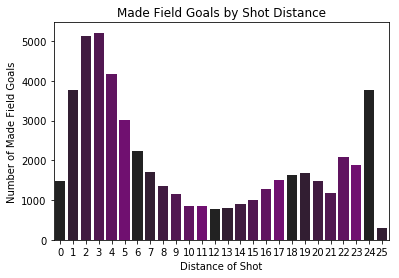

In [309]:
# Seing if the distribution of made field goals varies wildly from the distribution of taken field goals
df_2 = pd.DataFrame()
df_2['SHOT_DIST'] = df['SHOT_DIST']
df_2['FGM'] = df['FGM']
df_2['SHOT_DIST'] = df_2['SHOT_DIST'].astype(int)
df_2.round()
df_2 = df_2.groupby(['SHOT_DIST'], as_index=False).sum()
df_2.head()
dark = sns.dark_palette("purple")
sns.barplot(x='SHOT_DIST', y='FGM', data=df_2, palette=dark)
plt.title('Made Field Goals by Shot Distance')
plt.xlabel('Distance of Shot')
plt.ylabel('Number of Made Field Goals')

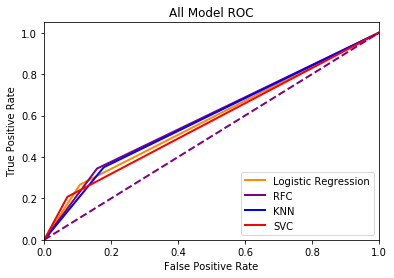

In [317]:
# All ROC graphs layered
plt.plot(fpr_l, tpr_l, color='darkorange',
         lw=lw, label='Logistic Regression')
plt.plot(fpr_r, tpr_r, color='purple',
         lw=lw, label='RFC')
plt.plot(fpr_k, tpr_k, color='blue',
         lw=lw, label='KNN')
plt.plot(fpr_s, tpr_s, color='red',
         lw=lw, label='SVC')
plt.plot([0, 1], [0, 1], color='purple', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All Model ROC')
plt.legend(loc="lower right")
plt.show()
